<a href="https://colab.research.google.com/github/martinfinis/HelloCodeSchoolProject/blob/master/covid_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Control and environment settings

In [ ]:
# try to crop the lung area only
bool_crop = True

# scale each image indepently - set the darkest pixel to zero and the lightest pixel to 255
bool_scale = False

# Random seed used in the notebook
RAND_SEED = 42

# Train InceptionV3 from scratch or load existing model 
REBUILD_INCEPTIONV3 = False

# Train Standard-CNN-Model from scratch or load existing model 
REBUILD_CNN = False

# Path variables
source_dir = '/content/curated_data/curated_data/'
train_dir = str(source_dir + 'train/')
test_dir = str(source_dir + 'test/')
validation_dir = str(source_dir + 'validation/')

# Path used to store and restore trained models
target_path = '/content/drive/.shortcut-targets-by-id/1lp7vo6EG60jba1Gk_tuNpvDm7q5ZXlKX/Telecom_Specialization_ML3/Students/Peter_Christoph_Marko_Martin/program/'

#Imports

In [ ]:
!pip install scikit-plot

In [ ]:
# Import required packages
from google.colab import drive
from google.colab.patches import cv2_imshow

import pylab as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import time
import os
import shutil
import tensorflow as tf
import cv2 as cv2

from IPython import display
from datetime import datetime

import scikitplot as skplt

from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import joblib
import lightgbm as lgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, InputLayer, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, MaxPool2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.python.keras.callbacks import History


%matplotlib inline

In [ ]:
!rm -r curated_data
!rm meta_data_cap.csv
!rm meta_data_covid.csv
!rm meta_data_normal.csv

# Helper Functions

In [ ]:
def load_imagelist_label(main_dir, sub_dirs, data_format='/*.png'):
  """
  helper function to create a img list and a label list from the data files
  takes use of the global variables classes_list and data_fromat
  """
  img_list = []
  label_list = []

  for case in sub_dirs:#in original version, just a hint -> dict_case_df.keys():#dict_case_lst can be delete after final run
    file_list = glob.glob(os.path.join(main_dir, case + data_format))
    
    for f in range(len(file_list)):  
      img = cv2.imread(file_list[f], cv2.IMREAD_GRAYSCALE)
      #img = cv2.resize(img, (224, 224))#uncommit for final version, done in other function 
      img_list.append(img)
      label_list.append(case)

  return np.array(img_list), np.array(label_list)

In [ ]:
# Find a filename of an image correctly predicted with highest confidence
def get_best_image_name(model, generator, class_string):
  """
  model: trained model
  generator: fitted generator
  class_string: one of generator.class_indices: {'CAP': 0, 'COVID': 1, 'NonCOVID': 2}
  Returns:
  - image_file_path of (one of) the image(s) in generator which was 
  correctly predicted as belonging to the given class - i.e. prediction for 
  given class is highest value.
  - softmax predictions for all classes for this image.
  """


  print(f"generator.directory: {generator.directory}")
  print(f"generator.class_indices: {generator.class_indices}")

  class_n = generator.class_indices[class_string]

  y_true = generator.classes

  # Predictions for data in generator
  y_predict_softmax = model.predict(generator)

  # Choose index of maximum
  y_predict_max = np.argmax(y_predict_softmax, axis=-1)

  # Filter where model correctly predicts class_n
  correct_pred_bool = np.logical_and(y_predict_max == class_n, y_true == class_n)
  # Set wrong predictions to Zero
  correct_preds_float = y_predict_softmax[:,class_n] * correct_pred_bool
  # Find index of maximum prediction
  index_of_max = np.argmax(correct_preds_float)

  predictions_at_max = y_predict_softmax[index_of_max]

  filename_at_max = generator.filenames[index_of_max]
  filepath = str(generator.directory + filename_at_max)

  print(f"True class of image: {y_true[index_of_max]}")
  print(f"Predicted class of image: {y_predict_max[index_of_max]}")

  return filepath, predictions_at_max


# Test code:

# Uncomment one line:
# filepath, predictions = get_best_image_name(best_model_cnn, test_generator, 'CAP')
# filepath, predictions = get_best_image_name(best_model_cnn, test_generator, 'COVID')
# filepath, predictions = get_best_image_name(best_model_cnn, test_generator, 'NonCOVID')

# print(filepath)
# print(predictions)

# img = plt.imread(filepath)
# plt.imshow(img, cmap='gray')


# Test code for loop over classes:

# for cl in test_generator.class_indices:
#   print(cl)
#   filepath, predictions = get_best_image_name(best_model_cnn, test_generator, cl)
#   print(filepath)
#   print(predictions)

#   img = plt.imread(filepath)
#   plt.xticks([])
#   plt.yticks([])
#   plt.imshow(img, cmap='gray')
#   plt.show()

In [ ]:
# Find a filename of an image wrongly predicted with highest confidence
def get_worst_image_name(model, generator, class_string):
  """
  model: trained model
  generator: fitted generator
  class_string: one of generator.class_indices: {'CAP': 0, 'COVID': 1, 'NonCOVID': 2}
  Returns:
  - image_file_path of (one of) the image(s) in generator which was 
  incorrectly predicted as NOT belonging to the given class with highest 
  confidence - i.e. prediction for given class is lowest value.
  - softmax predictions for all classes for this image.
  """


  print(f"generator.directory: {generator.directory}")
  print(f"generator.class_indices: {generator.class_indices}")

  class_n = generator.class_indices[class_string]

  y_true = generator.classes

  # Predictions for data in generator
  y_predict_softmax = model.predict(generator)

  # Choose index of maximum
  y_predict_max = np.argmax(y_predict_softmax, axis=-1)

  # Searching for images where model predicts class_n, but class_n not true
  filter_bool = np.logical_and(y_predict_max == class_n, y_true != class_n)

  # Filter out the other predictions (set to Zero)
  wrong_preds_float = y_predict_softmax[:,class_n] * filter_bool
  # Find index of maximum prediction
  index_of_max = np.argmax(wrong_preds_float)

  predictions_at_max = y_predict_softmax[index_of_max]
  filename_at_max = generator.filenames[index_of_max]
  filepath = str(generator.directory + filename_at_max)

  print(f"True class of image: {y_true[index_of_max]}")
  print(f"Predicted class of image: {y_predict_max[index_of_max]}")

  return filepath, predictions_at_max

# Test code:

# Uncomment one line:
# filepath, predictions = get_worst_image_name(best_model_cnn, test_generator, 'CAP')
# filepath, predictions = get_worst_image_name(best_model_cnn, test_generator, 'COVID')
# filepath, predictions = get_worst_image_name(best_model_cnn, test_generator, 'NonCOVID')

#print(filepath)
#print(predictions)

#img = plt.imread(filepath)
#plt.imshow(img, cmap='gray')


# Test code for loop over classes

# for cl in test_generator.class_indices:
#   print(cl)
#   filepath, predictions = get_worst_image_name(best_model_cnn, test_generator, cl)
#   print(filepath)
#   print(predictions)

#   img = plt.imread(filepath)
#   plt.xticks([])
#   plt.yticks([])
#   plt.imshow(img, cmap='gray')
#   plt.show()


In [ ]:
# Plot the training history of a neural network
def plot_training_history(history: History):
    fig, axs = plt.subplots(1, 2, figsize=(12,4))
    axs[0].plot(history.history['accuracy'], color='blue', label='train')
    axs[0].plot(history.history['val_accuracy'], color='orange', label='validation')
    axs[0].legend()
    axs[0].set_title('Classification Accuracy')
  
    axs[1].plot(history.history['loss'], color='blue', label='train')
    axs[1].plot(history.history['val_loss'], color='orange', label='validation')
    axs[1].legend()
    axs[1].set_title('Classification Loss')
    plt.show()

In [ ]:
# Save best model on Google Drive

def save_model_in_drive(model, model_name):

  # Initialize target path
  #target_path = '/content/drive/.shortcut-targets-by-id/1lp7vo6EG60jba1Gk_tuNpvDm7q5ZXlKX/Telecom_Specialization_ML3/Students/Peter_Christoph_Marko_Martin/program/'

  # Get Timestamp
  dateTimeObj = datetime.now()
  str_timestamp = dateTimeObj.strftime("%d_%b_%Y_%H_%M_%S")

  # Create model filename
  model_filename = str(model_name + "_" + str_timestamp)
  # Create complete filepath
  model_filepath = str(target_path + model_filename)

  # Save model
  model.save(model_filepath)
  print(f"Model saved: {model_filepath}")

  return

# Test code
# save_model_in_drive(best_model_cnn, "best_model_cnn")

In [ ]:
def plot_confusion_matrix_x(labels,predictions,classes_name):
  """
  example:
  predictions=max_predict # np.argmax(y_predict, axis=-1)
  labels=test_generator.classes
  classes_name = artist_list
  """

  normalize = False

  # con_mat = tf.math.confusion_matrix(labels=labels, predictions=np.argmax(predictions, axis=-1) ).numpy()
  con_mat = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

  if normalize == True:
    con_mat_df = pd.DataFrame(con_mat_norm,index = classes_name,columns = classes_name)
  else:
    con_mat_df = pd.DataFrame(con_mat,index = classes_name,columns = classes_name)


  figure = plt.figure(figsize=(4, 4))
  sns.heatmap(con_mat_df, annot=True,fmt='g',cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()




# Loading data

In [ ]:
# mount google drive to access dataset food
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# unzip the data on the virtual machine
%cd /content/

!unzip '/content/drive/.shortcut-targets-by-id/1lp7vo6EG60jba1Gk_tuNpvDm7q5ZXlKX/Telecom_Specialization_ML3/Students/Peter_Christoph_Marko_Martin/data/archive.zip'

In [ ]:
##### Inconsistency between file names and file names in meta data #####
## ==> rename files to the names used in meta_data_covid.csv
!mv "/content/curated_data/curated_data/2COVID/17_Zhao_Recurrence-of-positive-SARS-CoV-2-RNA-in-C_2020_International-Journal-of-Inf-p1-21%0.png" "/content/curated_data/curated_data/2COVID/17_Zhao_Recurrence-of-COVID-19-SARS-CoV-2-RNA-in-C_2020_International-Journal-of-Inf-p1-21%0.png"

!mv "/content/curated_data/curated_data/2COVID/17_Zhao_Recurrence-of-positive-SARS-CoV-2-RNA-in-C_2020_International-Journal-of-Inf-p1-21%1.png" "/content/curated_data/curated_data/2COVID/17_Zhao_Recurrence-of-COVID-19-SARS-CoV-2-RNA-in-C_2020_International-Journal-of-Inf-p1-21%1.png"

In [ ]:
# Load data as dataframes
df_meta_cap = pd.read_csv('meta_data_cap.csv')
df_meta_covid = pd.read_csv('meta_data_covid.csv', encoding = "ISO-8859-1")
df_meta_normal = pd.read_csv('meta_data_normal.csv')

# Split data into training, valdiation and test data

In [ ]:
np.random.seed(RAND_SEED)

# Configuration of sizes
test_size = 0.1
validation_size = 0.1

# List of classes
classes_list = [('1NonCOVID','NonCOVID'), 
                ('2COVID','COVID'), 
                ('3CAP','CAP')]

In [ ]:
# Get patient to image mappings

# Covid patients
covid_patient_to_image = df_meta_covid.groupby(['Patient ID'])['File name'].apply(list).reset_index()
# Normal patients
normal_patient_to_image = df_meta_normal.groupby(['Patient ID'])['File name'].apply(list).reset_index()
# CAP patients
cap_patient_to_image = df_meta_cap.groupby(['Patient ID'])['File name'].apply(list).reset_index()

In [ ]:
def split_ids(patient_to_image, val_size, test_size):
  '''
  '''
  np.random.seed(RAND_SEED)
  # Calculate the number of training, valdiation and test samples
  len_all = len(patient_to_image)
  nb_test = np.floor(len_all * test_size).astype('int')
  nb_val = np.floor(len_all * val_size).astype('int')
  nb_train = len_all - (nb_test + nb_val).astype('int')
  # Create sub-samples of patient_to_image
  patient_ids = patient_to_image.index.values
  train_ids = np.random.choice(patient_ids, nb_train, replace=False)
  val_ids = np.random.choice(list(set(patient_ids)-set(train_ids)), nb_val, 
                             replace=False)
  test_ids = np.random.choice(list(set(patient_ids)-set(train_ids)-set(val_ids)),
                              nb_test, replace = False)
  
  return train_ids, val_ids, test_ids

In [ ]:
# Split data into training, validation and test subsets

sample_id_dict = {}

for _, cl_dest in classes_list:
  if cl_dest == 'COVID':
    # Split covid patients
    covid_train_ids, covid_val_ids, covid_test_ids = \
      split_ids(covid_patient_to_image, validation_size, test_size)
    
    # Add data to dictionary
    sample_id_dict[cl_dest] = {'IMG':covid_patient_to_image,
                               'TRAIN':covid_train_ids,
                               'VAL':covid_val_ids,
                               'TEST':covid_test_ids}
  elif cl_dest == 'NonCOVID':
    # Split normal patients
    norm_train_ids, norm_val_ids, norm_test_ids = \
      split_ids(normal_patient_to_image, validation_size, test_size)
    # Add data to dictionary
    sample_id_dict[cl_dest] = {'IMG':normal_patient_to_image,
                               'TRAIN':norm_train_ids,
                               'VAL':norm_val_ids,
                               'TEST':norm_test_ids}
  else: # CAP
    # Split cap patients
    cap_train_ids, cap_val_ids, cap_test_ids = \
      split_ids(cap_patient_to_image, validation_size, test_size)
    # Add data to dictionary
    sample_id_dict[cl_dest] = {'IMG':cap_patient_to_image,
                               'TRAIN':cap_train_ids,
                               'VAL':cap_val_ids,
                               'TEST':cap_test_ids}

In [ ]:
# Create new directories for training, validation and test data
!mkdir $train_dir
!mkdir $test_dir
!mkdir $validation_dir

# Create subdirectories for each class
for _, cl in classes_list:
  c_train = str(train_dir + cl)
  !mkdir $c_train
  c_test = str(test_dir + cl)
  !mkdir $c_test
  c_validation = str(validation_dir + cl)
  !mkdir $c_validation

In [ ]:
def move_files(patient_to_image, patient_ids, from_dir, to_dir):
  '''
  '''
  # Set a limit to mv-strings
  MAX_LEN = 20000

  # Check if at least one patient id was provided
  if len(patient_to_image) < 1:
    print('No files to move!')
    return None

  fs_to_move_batch = []  # move files batch-wise to improve processing time
  fs_to_move = ''
  for id in patient_ids:
    file_names = f' {from_dir}'.join([fn for fn in patient_to_image.at[id,'File name']])
    # Extend fs_to_move by new file names and from_dir at the beginning
    fs_to_move = fs_to_move + f' {from_dir}' + file_names
    if len(fs_to_move) > MAX_LEN:
      fs_to_move_batch.append(fs_to_move)
      fs_to_move = ''
  if len(fs_to_move) > 0:
    # Append the last fs_to_move string to the file_stack
    fs_to_move_batch.append(fs_to_move)
  for fs_to_move in fs_to_move_batch:
    !mv $fs_to_move $to_dir 


In [ ]:
# Move all data to new destinations
%%time

for cl_src, cl_dest in classes_list:
  from_dir = source_dir + cl_src + '/'
  
  imgs = sample_id_dict[cl_dest]['IMG']

  # Move training data
  to_dir = train_dir + cl_dest
  ids = sample_id_dict[cl_dest]['TRAIN']
  move_files(imgs, ids, from_dir, to_dir)

  # Move validation data
  to_dir = validation_dir + cl_dest
  ids = sample_id_dict[cl_dest]['VAL']
  move_files(imgs, ids, from_dir, to_dir)

  # Move test data
  to_dir = test_dir + cl_dest
  ids = sample_id_dict[cl_dest]['TEST']
  move_files(imgs, ids, from_dir, to_dir)
  

CPU times: user 227 ms, sys: 591 ms, total: 818 ms
Wall time: 6.88 s


# research / the plan

1. using some U-Net to create a mask for the lung
1.1 create the U-Net on kaggle
1.2 there are some training data avaliable









k-means / DBSCAN

opencv


mask-r-cnn
https://towardsdatascience.com/computer-vision-instance-segmentation-with-mask-r-cnn-7983502fcad1


https://www.analyticsvidhya.com/blog/2019/07/computer-vision-implementing-mask-r-cnn-image-segmentation/

Image Segmentation with U-net and Keras!
https://www.youtube.com/watch?v=7qJzp3i62S8


177 - Semantic segmentation made easy (using segmentation models library)
https://www.youtube.com/watch?v=J_XSd_u_Yew&t=135s
https://github.com/bnsreenu/python_for_microscopists/blob/master/177_semantic_segmentation_made_easy_using_segm_models.py


google search 
how to segments lungs from ct scan python

how to install segmentation_models on kaggle
AttributeError: module 'keras.utils' has no attribute 'generic_utils'



# vgg16_unet

https://www.youtube.com/watch?v=mgdB7WezqbU
https://github.com/nikhilroxtomar/Semantic-Segmentation-Architecture/blob/main/TensorFlow/vgg16_unet.py



In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg16_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg16.get_layer("block3_conv3").output         ## (128 x 128)
    s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)

    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

if __name__ == "__main__":
    input_shape = (512, 512, 3)
    model = build_vgg16_unet(input_shape)
    model.summary()

Model: "VGG16_U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 512, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 512, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 256, 256, 64) 0           block1_conv2[0][0]               
________________________________________________________________________________________

## predict

In [ ]:
target_size = (512, 512)
input_shape = (512, 512, 3)
batch_size = 32

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=False)

model = build_vgg16_unet(target_size)

Found 1505 images belonging to 3 classes.


ValueError: ignored

In [ ]:
# =============================================================================
# Test train_generator (to visualize augmentations performed)
# =============================================================================

data_batch = train_generator.next()
imgs = data_batch[0]
labels = data_batch[1]

# Predict for test data
y_predict = model.predict(test_generator)

# Preprocessing

# Models using pre-cropped images

## Standard CNN Model

Found 13602 images belonging to 3 classes.
Found 1997 images belonging to 3 classes.
Found 1505 images belonging to 3 classes.


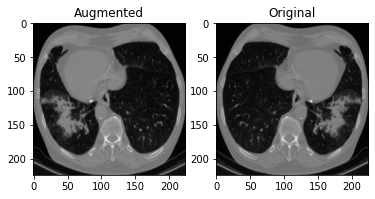

Original shape: (224, 224)
Augmented shape: (224, 224, 3)


In [ ]:

# =============================================================================
# ImageDataGenerator
# =============================================================================


# =============================================================================
# Paths and variables
# =============================================================================
    
target_size = (224, 224)
batch_size = 128
# batch_size = 32
    
# =============================================================================
# Set up data generators
# =============================================================================
    
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.,
        brightness_range = (0.7, 1.3),
        horizontal_flip=True,
        vertical_flip=False,
        rotation_range=0)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# read data from directory

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=False)
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=False)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=False)

# =============================================================================
# Test train_generator (to visualize augmentations performed)
# =============================================================================

data_batch = train_generator.next()
imgs = data_batch[0]
labels = data_batch[1]

# Der Generator merkt sich die Filenames aus dem flow_from_directory !!

orig_img_fn_list = train_generator.filenames

for i in range(batch_size):
    
    img = imgs[i]
    orig_img = plt.imread(str(train_dir + orig_img_fn_list[i]))
    f, ax = plt.subplots(1,2)
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Augmented')
    ax[1].imshow(orig_img, cmap='gray')
    ax[1].set_title('Original')
    plt.show()

    print(f"Original shape: {orig_img.shape}")
    print(f"Augmented shape: {img.shape}")

    break
    

In [ ]:
train_generator.shuffle = True

In [ ]:
# =============================================================================
# Define Model
# =============================================================================


input_shape = (224, 224, 3)


# Model parameters
learning_rate = 0.001
dec_rate = 0
optim = Adam(lr=learning_rate, decay=dec_rate)


def CNN_ConvLayers():
    model = Sequential()

    model.add(Conv2D(16, (2,2), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    # now: 112 x 112

    model.add(Conv2D(32, (2,2), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    # Try:
    model.add(Dropout(0.3))
    # now: 56 x 56

    model.add(Conv2D(64, (2,2), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    # Try:
    model.add(Dropout(0.3))
    # now: 28 x 28

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    return model

In [ ]:

# Compile Model
model = CNN_ConvLayers()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
batch_normalization_16 (Batc (None, 224, 224, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
batch_normalization_17 (Batc (None, 112, 112, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 32)        0

In [ ]:
# Fit Model and Save Best Model

if REBUILD_CNN:
  mcp = ModelCheckpoint('best_model_cnn', monitor='val_accuracy', save_best_only=True, verbose=1)
  # STEP_SIZE_TRAIN = 20
  STEP_SIZE_TEST = 5
  epochs=30
  history = model.fit(train_generator,
                      validation_data = validation_generator,
                      validation_steps = STEP_SIZE_TEST,
                      epochs=epochs,
                      callbacks=[mcp],
                      workers=8)




In [ ]:
# have a look at the predictions of the "best_model_cnn"

if REBUILD_CNN:
  from keras.models import load_model
  best_model_cnn = load_model('best_model_cnn')
  # save best model to drive (timestamp appended to filename)
  save_model_in_drive(best_model_cnn, "best_model_cnn_final")
else:
  # reload previously saved model from drive
  # model_source_path = '/content/drive/.shortcut-targets-by-id/1lp7vo6EG60jba1Gk_tuNpvDm7q5ZXlKX/Telecom_Specialization_ML3/Students/Peter_Christoph_Marko_Martin/program/'
  model_source_path = target_path
  model_source_file = 'best_model_cnn_final_29_Apr_2021_09_06_20'
  # print(str(model_source_path + model_source_file))
  best_model_cnn = load_model(str(model_source_path + model_source_file))

best_model_cnn.evaluate(test_generator)

12/12 [==============================] - 18s 191ms/step - loss: 0.6913 - acc: 0.7914


[0.6913032531738281, 0.7913621068000793]

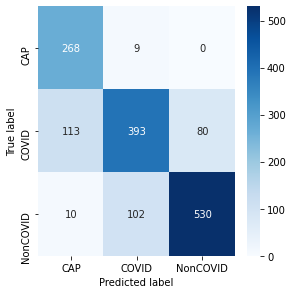

In [ ]:
test_generator.shuffle=False

# True classes
y_true = test_generator.classes

# Predict for test data
y_predict = best_model_cnn.predict(test_generator)
# Choose index of maximum
y_predict = np.argmax(y_predict, axis=-1)

plot_confusion_matrix_x(labels=y_true,predictions=y_predict,classes_name=['CAP', 'COVID', 'NonCOVID'])

In [ ]:
# Plot History

if REBUILD_CNN:
  plot_training_history(history)

In [ ]:
# Create Classification Report

from sklearn.metrics import classification_report

y_true = test_generator.classes

y_predict = best_model_cnn.predict(test_generator)
# Choose index of maximum
y_predict = np.argmax(y_predict, axis=-1)

print(classification_report(y_true, y_predict))

              precision    recall  f1-score   support

           0       0.69      0.97      0.80       277
           1       0.78      0.67      0.72       586
           2       0.87      0.83      0.85       642

    accuracy                           0.79      1505
   macro avg       0.78      0.82      0.79      1505
weighted avg       0.80      0.79      0.79      1505

